# Cox Mixtures with Heterogeneous Effects Demo
<img align="left" width=20% src=https://ndownloader.figshare.com/files/34052981>

## 1. Introduction

Estimation of treatment efficacy of real-world clinical interventions involves working with continuous outcomes such as time-to-death, re-hospitalization, or a composite event that may be subject to censoring. Causal reasoning in such scenarios requires decoupling the effects of confounding physiological characteristics that affect baseline survival rates from the effects of the interventions being assessed. In this paper, we present a latent variable approach to model heterogeneous treatment effects by proposing that an individual can belong to one of latent clusters with distinct response characteristics. We show that this latent structure can mediate the base survival rates and helps determine the effects of an intervention. We demonstrate the ability of our approach to discover actionable phenotypes of individuals based on their treatment response on multiple large randomized clinical trials originally conducted to assess appropriate treatment strategies to reduce cardiovascular risk.

<img  src="https://ndownloader.figshare.com/files/34056269">

<img align="center" width=35% src="https://figshare.com/ndownloader/files/34056284">

## 2. Synthetic Data Example

In [21]:
import sys
sys.path.append('../auton_survival/')

from datasets import load_dataset
from example_utils import * 

# Load the synthetic dataset
outcomes, features, interventions = load_dataset(dataset='SYNTHETIC')

### Hyper-parameters

In [22]:
# Hyper-parameters
random_seed = 0
test_size = 0.25

# Split the synthetic data into training and testing data
import numpy as np

np.random.seed(random_seed)
n = features.shape[0] 

test_idx = np.zeros(n).astype('bool')
test_idx[np.random.randint(n, size=int(n*test_size))] = True 

features_tr = features.iloc[~test_idx] 
outcomes_tr = outcomes.iloc[~test_idx]
interventions_tr = interventions[~test_idx]
print(f'Number of training data points: {len(features_tr)}')

features_te = features.iloc[test_idx] 
outcomes_te = outcomes.iloc[test_idx]
interventions_te = interventions[test_idx]
print(f'Number of test data points: {len(features_te)}')

Number of training data points: 3899
Number of test data points: 1101


In [23]:
# Hyper-parameters to train model

k = 2 # Number of underlying base survival phenotypes
g = 2 # Number of underlying treatment effect phenotypes
layers = [50] # Number of neurons in each hidden layer.

model_random_seed = 0
iters = 50
learning_rate = 1e-3
batch_size = 128
vsize = 0.15
optimizer = "Adam"

In [24]:
import torch

# Set torch and numpy random seeds
torch.manual_seed(model_random_seed)
np.random.seed(model_random_seed)

# Convert training data into torch tensors
x = features_tr.values.astype('float32')
t = outcomes_tr['time'].values.astype('float32')
e = outcomes_tr['event'].values.astype('float32')
a = interventions_tr.values.astype('float32')
print(f'Shape of covariates: {x.shape} | times: {t.shape} | events: {e.shape} | interventions: {a.shape}')

from models.cmhe import DeepCoxMixturesHeterogenousEffects

# Instantiate the CMHE model
model = DeepCoxMixturesHeterogenousEffects(k=k, g=g, layers=layers)

model = model.fit(x, t, e, a, vsize=vsize, val_data=None, iters=iters, 
                  learning_rate=learning_rate, batch_size=batch_size, 
                  optimizer=optimizer, random_state=model_random_seed)

Shape of covariates: (3899, 8) | times: (3899,) | events: (3899,) | interventions: (3899,)


 48%|████████████████████▏                     | 24/50 [00:50<00:54,  2.09s/it]


In [25]:
print(f'Treatment Effect for the {g} groups: {model.torch_model[0].omega.detach()}')

x = features_tr.values.astype('float32')
a = interventions_tr.values.astype('float32')
zeta_probs_train = predict_treatment_phenotype_proba(model, x, a)

zeta_train =  np.argmax(zeta_probs_train, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CMHE = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CMHE} has the maximum restricted mean survival time on the training data!')

Treatment Effect for the 2 groups: tensor([-0.1574, -0.0178])
Distribution of individuals in each treatement phenotype in the training data: [1939 1960]

Group 1 has the maximum restricted mean survival time on the training data!


/zfsauton2/home/mgoswami/anaconda3/envs/cox-subgroup/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


In [26]:
from importlib import reload
import example_utils
reload(example_utils)

<module 'example_utils' from '/zfsauton2/home/mgoswami/auton-survival/examples/example_utils.py'>

In [27]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

# Change the testing data to torch tensors
x = features_te.values.astype('float32')
a = interventions_te.values.astype('float32')

zeta_probs_test_CMHE = predict_treatment_phenotype_proba(model, x, a)
zeta_test =  np.argmax(zeta_probs_test_CMHE, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test, return_counts=True)[1]}')

Distribution of individuals in each treatement phenotype in the test data: [539 562]


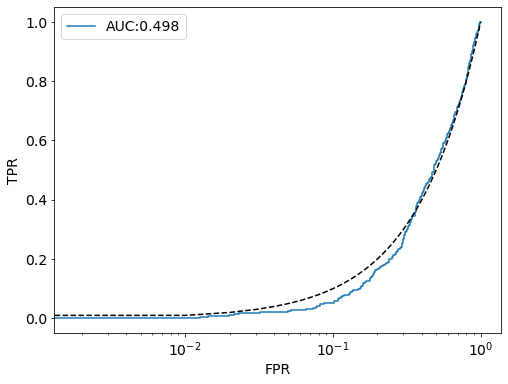

In [28]:
# Now let us evaluate our performance
example_utils.plot_phenotypes_roc(outcomes_te, zeta_probs_test_CMHE[:, max_treat_idx_CMHE])

## Comparison with the Clustering phenotyper

In [29]:
from phenotyping import ClusteringPhenotyper
from sklearn.metrics import auc

clustering_method = 'kmeans'
dim_red_method = None # We would not perform dimensionality reduction for the synthetic dataset
n_components = None 
n_clusters = g # Number of underlying treatment effect phenotypes

# Running the phenotyper
phenotyper = ClusteringPhenotyper(clustering_method=clustering_method, 
                                  dim_red_method=dim_red_method, 
                                  n_components=n_components, 
                                  n_clusters=n_clusters)

zeta_probs_train = phenotyper.fit_phenotype(features_tr.values)
zeta_train = np.argmax(zeta_probs_train, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the training data: \
{np.unique(zeta_train, return_counts=True)[1]}')

max_treat_idx_CP = find_max_treatment_effect_phenotype(
    g=2, zeta_probs=zeta_probs_train, factual_outcomes=(outcomes_tr, interventions_tr))
print(f'\nGroup {max_treat_idx_CP} has the maximum restricted mean survival time on the training data!')

No Dimensionaity reduction specified...
 Proceeding to learn clusters with the raw features...
Fitting the following Clustering Model:
 KMeans(n_clusters=2)
Distribution of individuals in each treatement phenotype in the training data: [1447 2452]

Group 1 has the maximum restricted mean survival time on the training data!


/zfsauton2/home/mgoswami/anaconda3/envs/cox-subgroup/lib/python3.8/site-packages/lifelines/fitters/__init__.py:204: ApproximationWarning: Approximating using linear interpolation`.

  warnings.warn("Approximating using linear interpolation`.\n", exceptions.ApproximationWarning)


In [30]:
# Now for each individual in the test data, let's find the probability that 
# they belong to the max treatment effect group

# Change the testing data to torch tensors
x = features_te.values.astype('float32')
a = interventions_te.values.astype('float32')

# Use the phenotyper trained on training data to phenotype on testing data
zeta_probs_test_CP = phenotyper.phenotype(features_te.values)
zeta_test_CP =  np.argmax(zeta_probs_test_CP, axis=1)
print(f'Distribution of individuals in each treatement phenotype in the test data: \
{np.unique(zeta_test_CP, return_counts=True)[1]}')

Distribution of individuals in each treatement phenotype in the test data: [423 678]


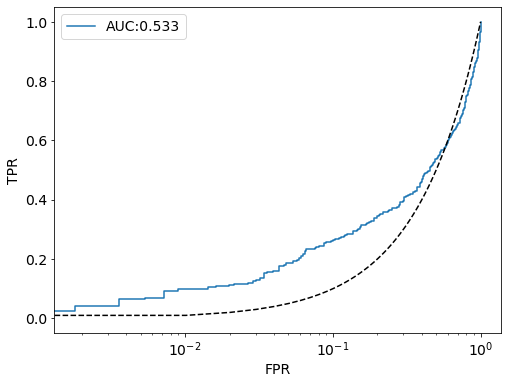

In [31]:
# Now let us evaluate our performance
example_utils.plot_phenotypes_roc(outcomes_te, zeta_probs_test_CP[:, max_treat_idx_CP])